In [ ]:
import torch
from torch import nn

BERT modeli sıradan Transformer mimarisi ile ufak tefek kısımlarda farklılık gösterir. Bu çalışmada BERT base modeli oluşturulmuştur. Base modelin 12 adet encoder layerı, feedforward katmanındaki hidden_size'ı 3072 ve attention kısmında 12 adet head'i vardır. Large modelde ise bu sayılar sırasıyla 24, 4096 ve 16'dır. Ayrıca klasik Vanilla Transformer mimarisi ile farkları embedding vektörün iki model için 512 yerine sırasıyla 768 ve 1024 olması, positional embeddinglerin absolute (sabit indislerle toplamı (context_length kadar olacak)) olmasıdır.

Ayrıca tokenizer olarak BERT modelleri LLaMA ve GPT modellerinin aksine Byte Pair Encoding yerine WordPice tokenizer kullanır. Kullanılan bu tokenizerdaki sözlük boyutu yaklaşık 30000 tokendır.

In [ ]:
BERT_CONFIGS = {
  'n_base_encoders' : 12,
  'n_heads' : 12,
  'hidden_size' : 3072,
  'embed_size' : 768,
  'context_length' : 512,
  'vocab_size' : 30000
}

BERT'in açılımı Bidirectional Encoder Representations from Transformers'tır. Dolayısıyla bu modellerde LLaMA ve GPT modellerinin aksine tokendan önceki kısımların maskelenmesini bekleyemeyiz. Ayrıca BERT modellerinde LLaMA ve GPT modellerinin aksine taskler prompt yürütülmez ve metin oluşturma görevi için eğitilmez.

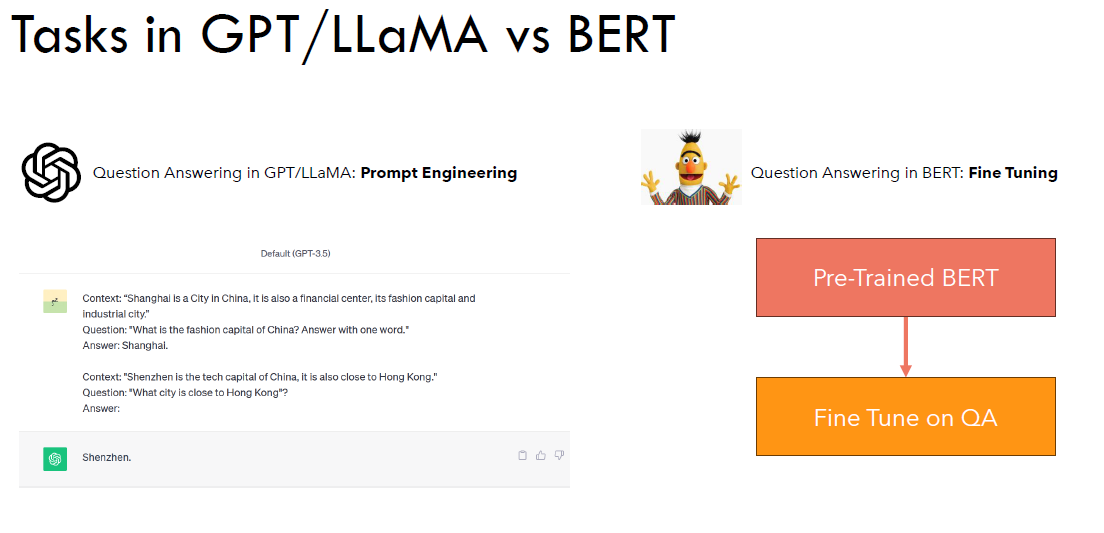

MLM (Masked Language Model) ve NTP (Next Token Prediction) görevleri için kullanılır. BERT modellerinde Embedding kısmında normal modellerden farklı olarak segmentasyon embeddingi de vardır. BERT modelleri mimari olarak bu aşamalarda LLaMA ve GPT gibi modellerden farklılık gösterir.

** Masked Language Model (MLM): Bir cümledeki rastgele seçilen metni maskeler ve model de sağ ve sol bağlamdan yola çıkarak kelimeyi tahmin eder. Maskelenen kelime genellikle özel bir token olan [MASK] ile kapatılır.

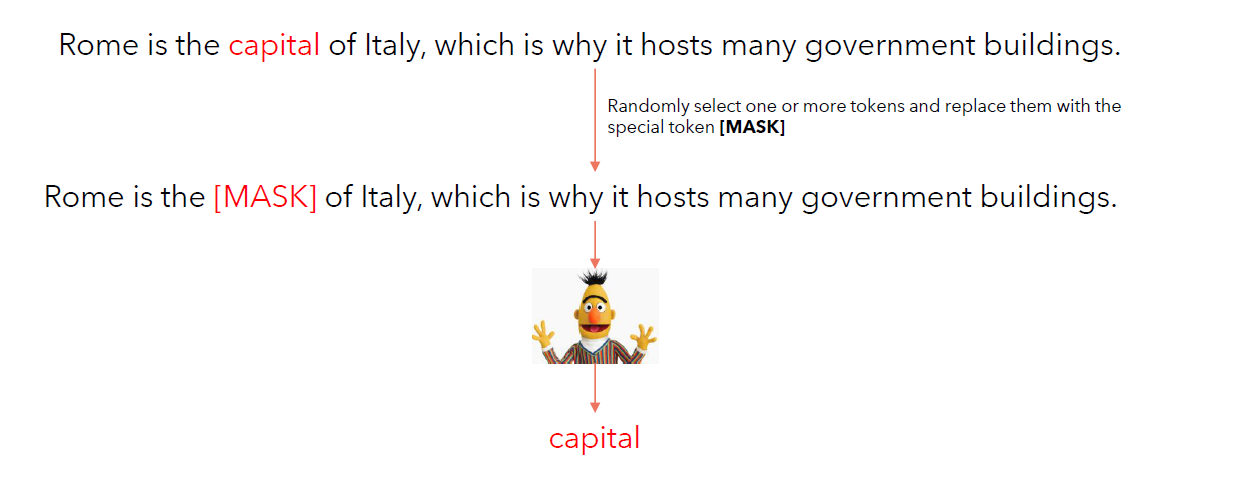

Yukarıdaki örnekte görüldüğü üzere maskelenen metindeki tokenların eğitim aşamasında %15'i maskelenir. Maskeleme için seçilen token %80 olasılıkla maskelenir, %10 olasılıkla başka bir tokenla değiştirilir, %10 olasılıkla hiçbir şey yapılmaz.

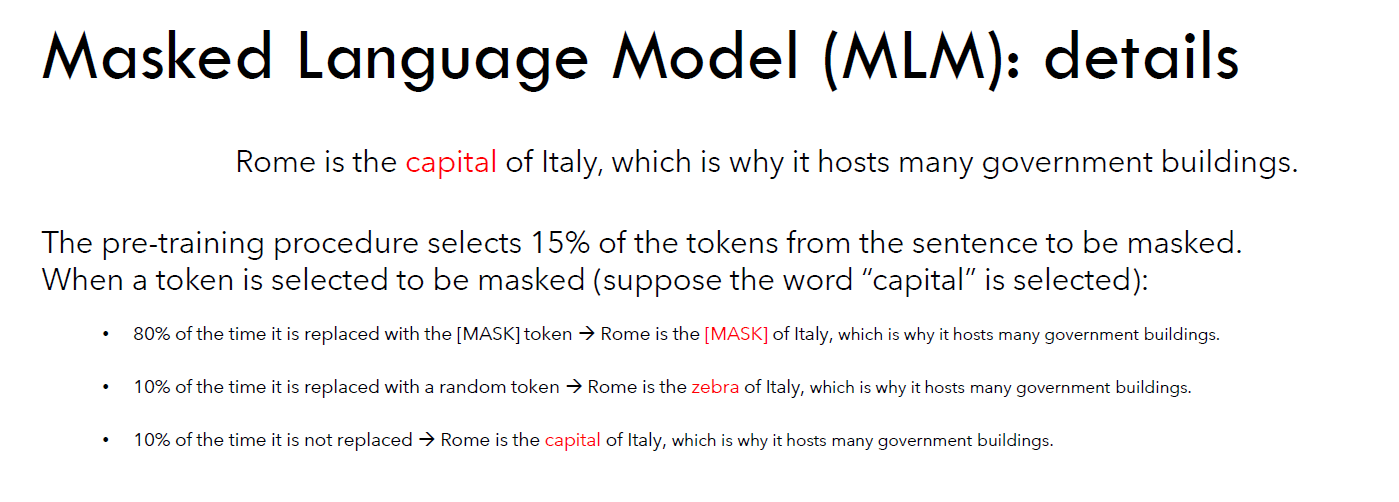

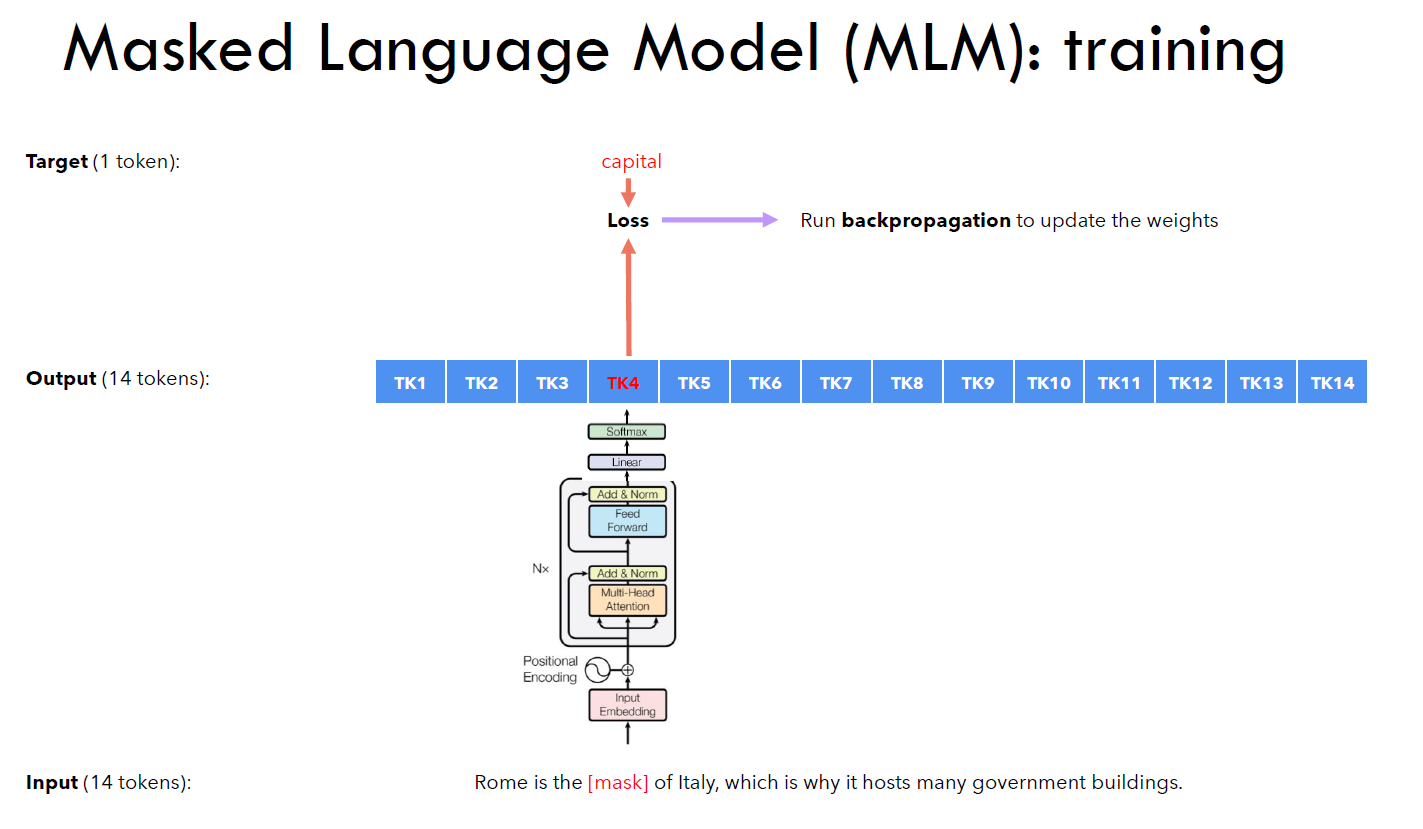

** Next Sentence Prediciton: Tokenlar yerine cümleler arasındaki ilişkiyi öğrenmeyi sağlar iki cümle verilir ve model bunların sonraki cümle olup olmadığını anlar.

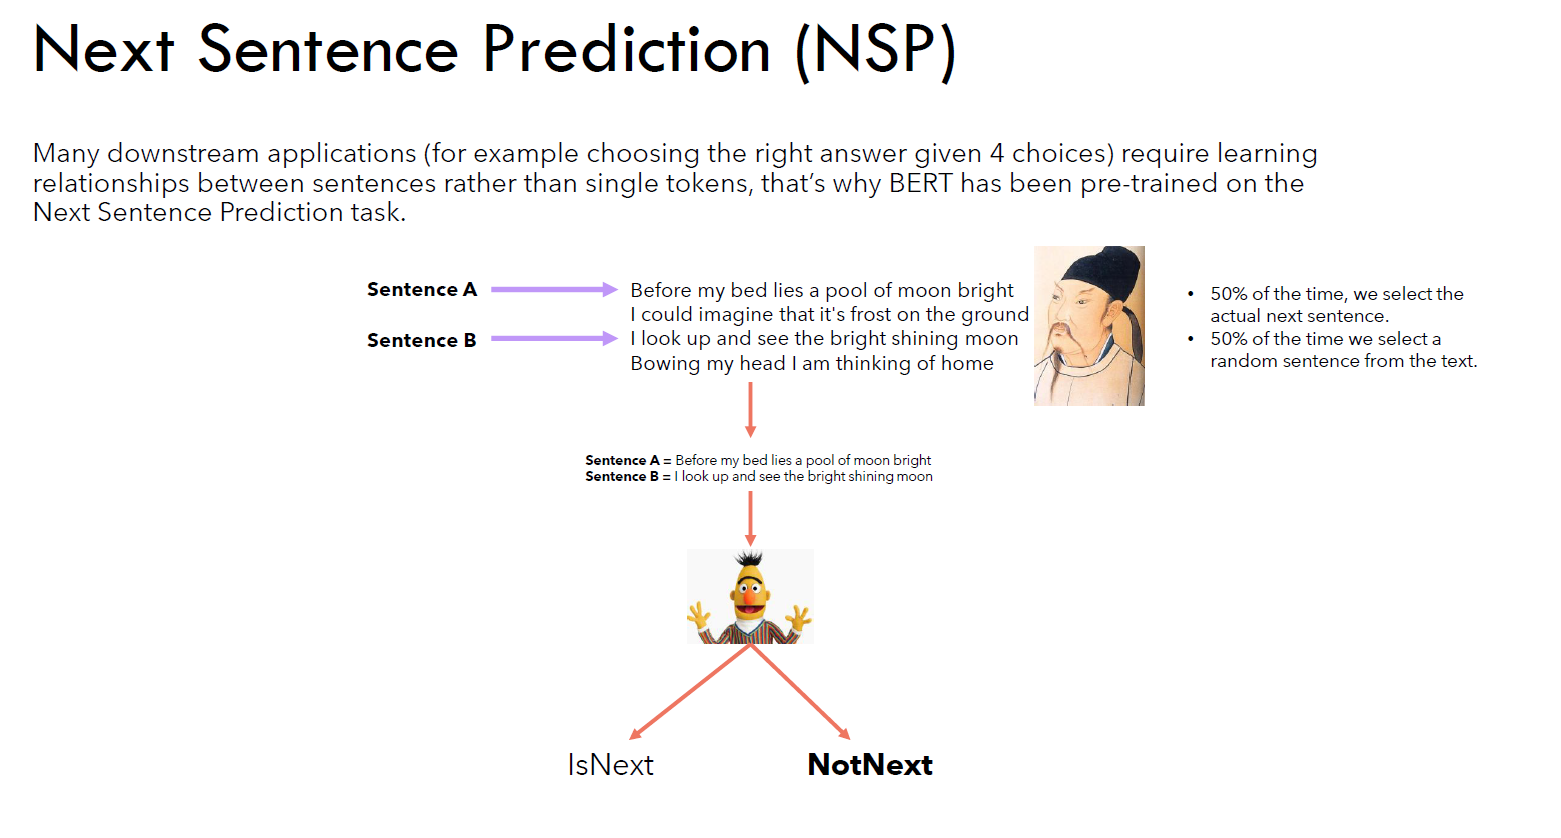

Peki Bunu Nasıl Anlar?: LLamMA ve GPT gibi modellerden de bildiğimiz position embeddinglerin üzerine token embeddingleri de eklenir. Buraya kadar her şey normal BERT modellerinde ekstra segment embedding denilen hangi tokenın hangi cümleye ait olduğunu belirten embedding de eklenir ve bu sayede bulunur. Ayrıca cümle başına [CLS] tokenı (cümle sınıflandırma için kullanılır. Diğer tokenlar NTP görevinde kullanılır dolayısıyla cümleyi en iyi temsil eden token [CLS] tokenıdır) ve cümleleri ayıran [SEP] tokenı da kullanılır.

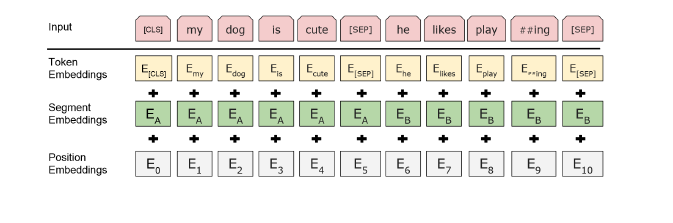

Yukarıda da belirtildiği üzere BERT modelinde herhangi bir görev yapılırken [CLS] tokenı dikkate alınır dolayısıyla CLS tokenına göre backpropagation çalışır.

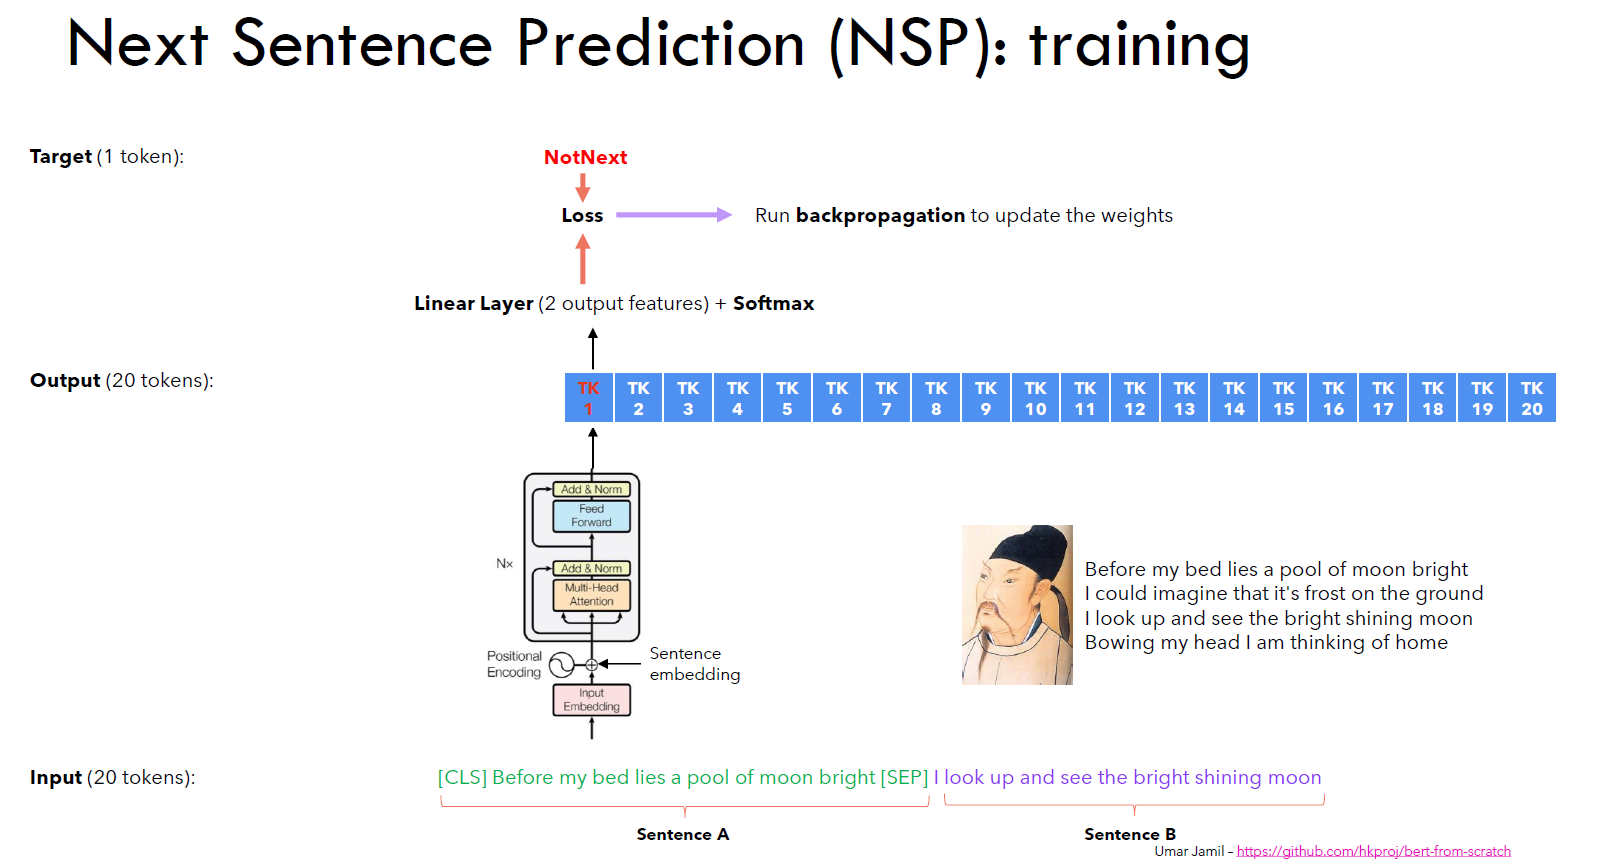

In [ ]:
class BertEmbeddings(nn.Module):
  def __init__(self, vocab_size:int, embed_size:int, context_length:int) -> None:
    super().__init__()
    self.first_embed = nn.Embedding(vocab_size, embed_size)
    self.pos_embed = nn.Embedding(context_length, embed_size)
    # BERT modellerinde QA, classification gibi görevlerde önemli olan [CLS] tokenı ve cümle ayırma görevi için kullanılan [SEP] tokenları için embedding oluşturuyoruz.
    self.segment_embed = nn.Embedding(2, embed_size)
    self.layer_norm = nn.LayerNorm(embed_size)
    self.dropout = nn.Dropout(0.1)

  def forward(self, x:torch.Tensor, token_type_ids:torch.Tensor=None) -> torch.Tensor:
    batch_size, seq_len = x.shape
    pos = torch.arange(0, seq_len).unsqueeze(0)
    # Bu segmente edilen cümlelerin id bilgilerini tutar. Örneğin 2 farklı cümle varsa şu şekilde olur.
    #         [CLS] Bu birinci cümle [SEP] Bu da ikinci cümle
    # seg_ids  A    A    A       A     A   B  B  B       B
    # en sonunda pos_encoding + seg_ids + segment_embed olur.
    seg_ids = token_type_ids if token_type_ids is not None else torch.zeros_like(x)
    emb = self.first_embed(x) + self.pos_embed(pos) + self.segment_embed(seg_ids)
    return self.dropout(self.layer_norm(emb))

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in:int, d_out:int, n_heads:int, dropout:float=0.1, qkv_bias:bool=False) -> None:
    super().__init__()
    assert d_out % n_heads == 0, 'd_out boyutu head sayısına tam bölünmelidir.'
    self.d_h = d_out // n_heads
    self.n_heads = n_heads
    self.w_q = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.w_k = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.w_v = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.dropout = nn.Dropout(dropout)
    # LLaMA, GPT gibi modellerde Causal Mask yaparak modelin sonraki tokenları görmemesi amaçlanır ama BERT modelinde böyle bir durum yoktur.
  def forward(self, x:torch.Tensor,attention_mask:torch.Tensor=None) -> torch.Tensor:
    batch_size, num_tokens, d_out = x.shape
    q = self.w_q(x)
    k = self.w_k(x)
    v = self.w_v(x)
    q = q.view(batch_size, num_tokens, self.n_heads, self.d_h).transpose(1,2)
    k = k.view(batch_size, num_tokens, self.n_heads, self.d_h).transpose(1,2)
    v = v.view(batch_size, num_tokens, self.n_heads, self.d_h).transpose(1,2)
    attn_scores = q @ k.transpose(2, 3)
    attn_scores = attn_scores / (self.d_h **0.5)
    # attn_scores ile aynı boyutta bir attention_mask oluşturulur bu maskta 0 a gelen yerler istenmeyen tokenlardır bunlara -inf vererek softmaxten 0 olarak çıkmasını sağlıyoruz.
    if attention_mask is not None:
      attn_scores = attn_scores.masked_fill(attention_mask==0, -1e9)
    attn_weights = torch.softmax(attn_scores, dim=-1)
    out_tensor = attn_weights @ v 
    out_tensor = out_tensor.transpose(1, 2).contiguous().view(batch_size, num_tokens, d_out)
    out_tensor = self.dropout(out_tensor)
    return out_tensor

In [ ]:
class GELU(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.gelu = nn.GELU()
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.gelu(x)

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, d_in:int, hidden_size:int, d_out:int) -> None:
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(d_in, hidden_size, bias = False),
        GELU(),
        nn.Linear(hidden_size, d_out, bias = False),
        nn.Dropout(0.1)
    )
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.layers(x)

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg:dict) -> None:
        super().__init__()
        self.mha = MultiHeadAttention(cfg['embed_size'], cfg['embed_size'], cfg['n_heads'])
        self.norm1 = nn.LayerNorm(cfg['embed_size'])
        self.ffn   = FeedForward(cfg['embed_size'], cfg['hidden_size'], cfg['embed_size'])
        self.norm2 = nn.LayerNorm(cfg['embed_size'])
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, attention_mask=None):
        x = x + self.dropout(self.mha(self.norm1(x), attention_mask))
        x = x + self.dropout(self.ffn(self.norm2(x)))
        return x


In [ ]:
class BERT(nn.Module):
    def __init__(self, cfg:dict) -> None:
        super().__init__()
        self.embedding = BertEmbeddings(cfg['vocab_size'], cfg['embed_size'], cfg['context_length'])
        self.encoder = nn.ModuleList([TransformerBlock(cfg) for _ in range(cfg['n_base_encoders'])])
        self.pooler  = nn.Linear(cfg['embed_size'], cfg['embed_size'])
        self.activation = nn.Tanh()
        # MLM Head işlemi. Buradaki amaç bazı tokenları maskeleyip tahmin etmektir.
        # Örneğin The capital of Italy is Rome cümlesinde capital maskelenecek olursa:
        # The [MASK] of Italy is Rome olur. Burada model çıktısı bir kelime olup Rome ile loss u hesaplanır ve backpropagation'a alınır.
        # Bu işlemde kelime %80 olasılıkla maskelenir, %10 olasılıkla başka bir tokenla değiştirilir ve %10 olasılıkla hiçbir şey olmaz.
        # Dolayısıyla maskelenen kelime tahmin edileceği için ve bu işlem vocab içerisindeki kelimelerden yapılacağı için ayrıca self.pooler'a bağlı olduğu için boyutlar embed_size, vocab_size kadar olur.
        # Ayrıca weight tying işlemi ile self.mlm_head in ağırlıkları embed e bağlanır.
        self.mlm_head = nn.Linear(cfg['embed_size'], cfg['vocab_size'], bias=False) # -> vocab_size, embed_size
        self.mlm_head.weight = self.embedding.first_embed.weight  # weight tying

    def forward(self, x, token_type_ids=None, attention_mask=None):
        x = self.embedding(x, token_type_ids)
        for layer in self.encoder:
            x = layer(x, attention_mask)
        # pooled output (CLS) -> NSP veya diğer görevler için
        pooled = self.activation(self.pooler(x[:,0]))
        mlm_logits = self.mlm_head(x)
        return mlm_logits, pooled   # x: tüm gizli durumlar, pooled: [CLS]


In [ ]:
bert_model = BERT(BERT_CONFIGS)

In [ ]:
bert_model

BERT(
  (embedding): BertEmbeddings(
    (first_embed): Embedding(30000, 768)
    (pos_embed): Embedding(512, 768)
    (segment_embed): Embedding(2, 768)
    (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ModuleList(
    (0-11): 12 x TransformerBlock(
      (mha): MultiHeadAttention(
        (w_q): Linear(in_features=768, out_features=768, bias=False)
        (w_k): Linear(in_features=768, out_features=768, bias=False)
        (w_v): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=False)
          (1): GELU(
            (gelu): GELU(approximate='none')
          )
          (2): Linear(in_features=3072, out_features=768, bias=False)
          (3): Dropout(p=

In [ ]:
model_params = sum(p.numel() for p in bert_model.parameters())
trainable_model_params = sum(p.numel() for p in bert_model.parameters() if p.requires_grad == True)

print(f"BERT modeli parametre sayısı: {model_params:,}")
print(f"BERT modeli eğitilebilir parametre sayısı: {trainable_model_params:,}")

BERT modeli parametre sayısı: 101,920,512
BERT modeli eğitilebilir parametre sayısı: 101,920,512


In [ ]:
inp = torch.randint(1, BERT_CONFIGS['vocab_size'], (BERT_CONFIGS['context_length'],)).unsqueeze(0)
out = bert_model(inp)
print(out)

(tensor([[[ -37.1749,   21.0825,  -81.4738,  ...,   18.4453,   34.0136,
          -130.5890],
         [ -17.3868,   44.5416,   -9.1394,  ...,   -9.2719,   88.3750,
          -105.0556],
         [ -17.8220,  -16.6579,  -25.5337,  ...,  -20.5849,   59.9404,
           -53.1360],
         ...,
         [ -42.8591,   16.9937,  -64.8031,  ...,  -30.6265,   94.4409,
           -73.7991],
         [  -7.0401,   37.7196,  -44.3398,  ...,  -60.8217,   75.5800,
           -88.4579],
         [-120.0362,   47.1677,  -71.4157,  ...,    5.9859,   62.4638,
           -68.1297]]], grad_fn=<UnsafeViewBackward0>), tensor([[-0.3142,  0.2953, -0.9435,  0.4267, -0.8865,  0.7073, -0.2886,  0.0865,
         -0.6722, -0.7779, -0.2556,  0.2905, -0.9619,  0.8129,  0.8238, -0.7704,
         -0.9597, -0.9506,  0.7177,  0.7595,  0.4314,  0.9605, -0.8090,  0.0446,
         -0.5661,  0.7229,  0.9600, -0.4753,  0.2242,  0.9981,  0.6542,  0.9637,
         -0.7351,  0.4574, -0.3266,  0.7811, -0.1159,  0.4039, -0.150

In [ ]:
inp = torch.randint(1, BERT_CONFIGS['vocab_size'], (BERT_CONFIGS['context_length'],)).unsqueeze(0)
out = bert_model(inp)
out[0].shape, out[1].shape

(torch.Size([1, 512, 30000]), torch.Size([1, 768]))

Şimdi gelelim BERT modellerini Finetune etme işlemine. BERT modellerinde bahsedildiği üzere en çok bilgi içeren token [CLS] tokenıdır. Çünkü diğer tokenlar NTP görevinde kullanılabilir. Dolayısıyla Finetune'da önemli bir rol oynayacak token [CLS] tokenıdır.

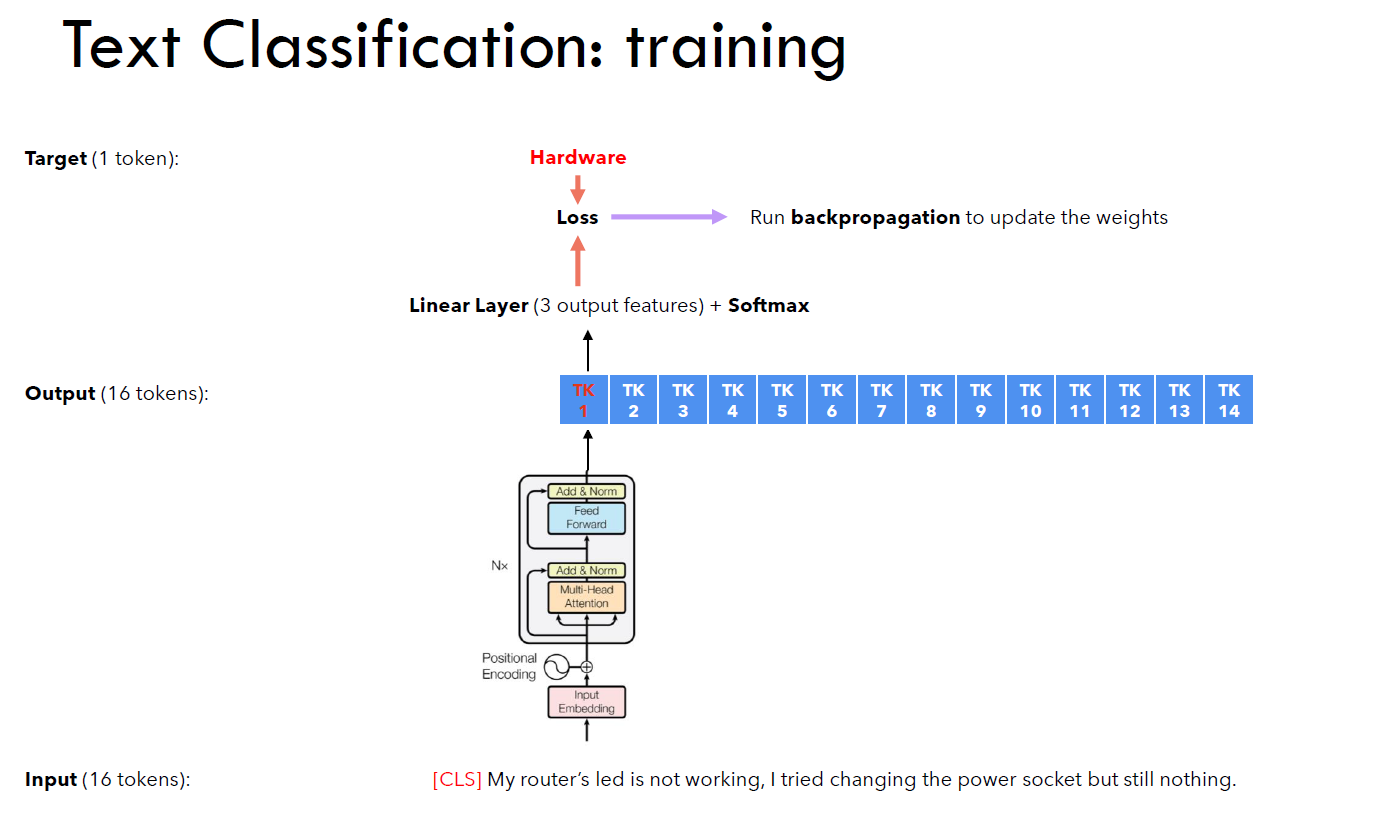

Soru cevaplama işleminde ise BERT modelinin hangi cümlenin soru hangisinin cevap olduğunu anlaması ve cevabın başlangıç ile bitiş tokenını tespit etmesi gerekmektedir. Soru cevap cümlelerini anlama kısmı segmentasyon embedding'i ile mümkündür. Başlangıç ve bitiş tokenlarının tespiti ise [CLs] tokenını modele vererek model çıktısından elde edilir.

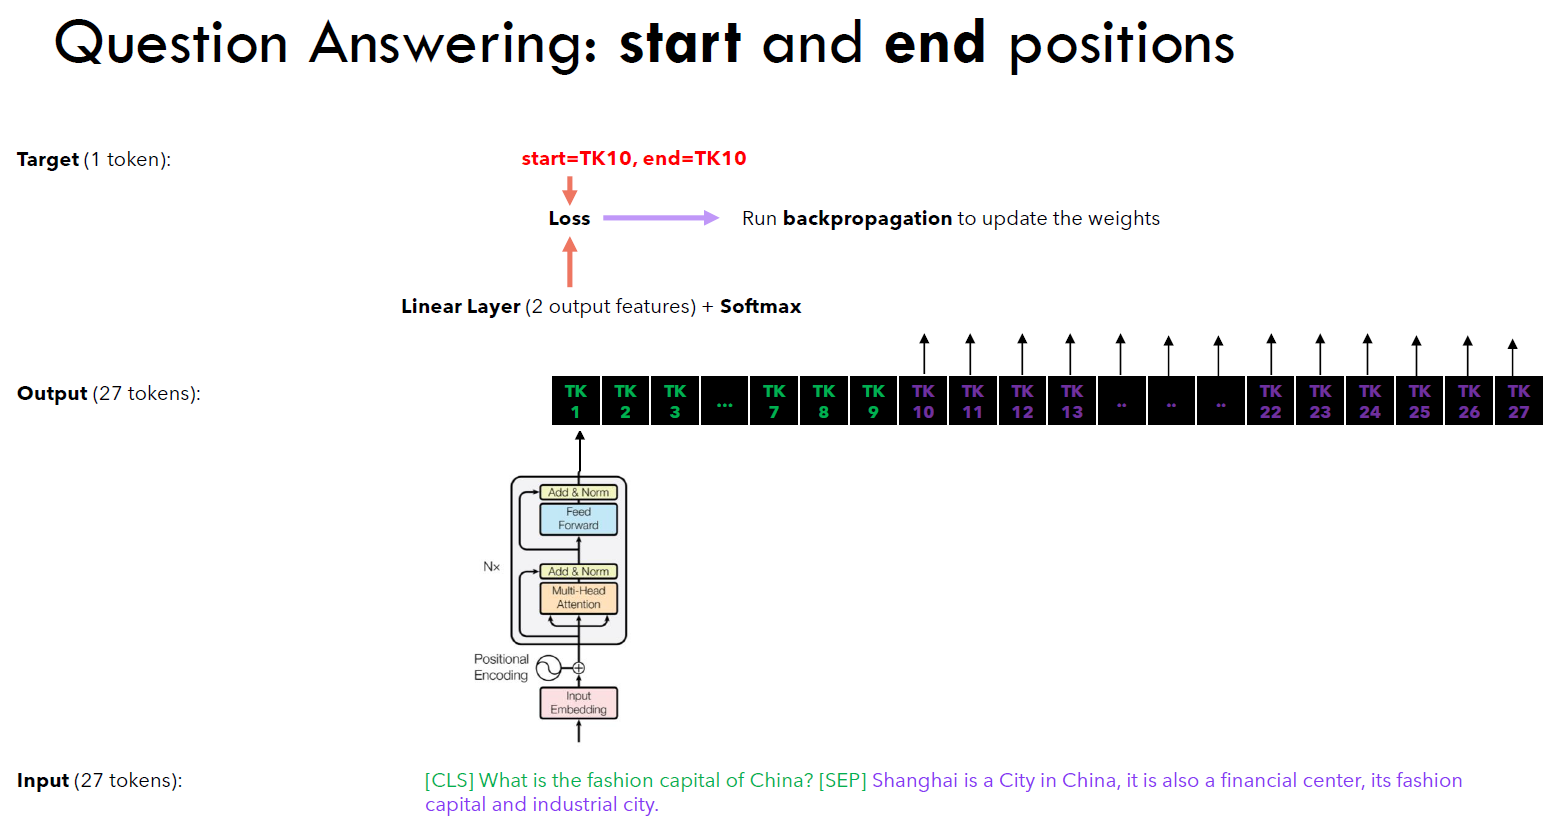

BERT Classification : https://www.kaggle.com/code/s7522k/classification-with-bert/notebook?scriptVersionId=264870666

BERT Question Answering: https://www.kaggle.com/code/s7522k/qa-with-bert/notebook?scriptVersionId=264870660